In [1]:
import plotly
import plotly.graph_objs as go
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from collections import Counter

from scipy.special import expit

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score, GridSearchCV
from sklearn import tree

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from optbinning import BinningProcess, OptimalBinning # Para cáclulos WOE e IV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2, l1

from tabulate import tabulate

import statsmodels.api as sm
import statsmodels.formula.api as smf

2025-06-21 12:39:11.612484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
data = pd.read_csv('vacuum_sensor_data.csv', sep = ';')
data

,momento,1-0005,5-0005,1-_006,5-_006,1-_007,5-_007,1-_008,5-_008,1-_010,...,1-_098,5-_098,1-_099,5-_099,1-0112,5-0112,1-0116,5-0116,1-0109,5-0109
0,1,-588.88,-580.21,-590.50,-582.25,-593.51,-585.46,-595.51,-587.47,-575.36,...,-588.17,-581.42,-594.26,-586.26,-589.46,-581.75,-592.92,-586.26,-593.93,-586.30
1,2,-588.38,-579.71,-590.80,-582.46,-593.80,-585.67,-595.55,-587.59,-574.11,...,-588.34,-581.63,-594.51,-586.26,-589.29,-581.58,-592.80,-586.26,-594.13,-586.51
2,3,-584.41,-575.74,-585.83,-577.66,-591.38,-583.21,-589.84,-578.04,-563.34,...,-588.17,-581.33,-592.88,-584.34,-588.50,-580.62,-590.21,-583.75,-593.68,-585.84
3,4,-573.73,-565.27,-570.31,-562.81,-578.91,-571.24,-578.61,-565.90,-555.00,...,-584.79,-576.87,-580.62,-568.15,-586.96,-578.75,-578.66,-571.19,-590.88,-582.63
4,5,-567.27,-558.55,-562.26,-554.55,-570.69,-562.93,-567.18,-557.51,-545.99,...,-579.11,-570.99,-572.11,-560.43,-583.45,-574.91,-571.06,-563.56,-587.38,-578.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,637,-237.18,-253.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,638,-237.10,-253.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,639,-237.14,-253.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,640,-237.10,-253.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
#rename column to have consistent naming 
import re

def clean_column(col):
    if col == 'momento':
        return col
    match = re.match(r"(\d)-_?(\d+)", col)
    if match:
        sensor, comp = match.groups()
        return f"{sensor}-{int(comp):04d}"
    return col  # fallback in case format is already correct

# Apply renaming
data.columns = [clean_column(col) for col in data.columns]

In [41]:
# drop rows(seconds) where data from any sensor is missing
data=data.dropna(axis=0)

In [65]:
data.shape

(151, 77)

In [64]:
# narrow the time window
data=data.iloc[49:200] 


In [66]:
#split columns into train and validation
defective_columns = ['1-0116', '5-0116', '1-0109', '5-0109']
normal_control_columns = ['1-0008', '5-0008', '1-0064', '5-0064']
validation_columns = defective_columns + normal_control_columns

df_validation = data[['momento'] + validation_columns]
train_columns = [col for col in data.columns if col not in validation_columns]
df_train = data[train_columns]


In [67]:
# Sequence Creation Function
def create_sequences(df, window_size, overlap):
    """
    Create overlapping sequences from a DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input data without 'momento' column
        window_size (int): Number of time steps in each window
        overlap (int): Number of overlapping steps between windows
        
    Returns:
        np.ndarray: 3D array of shape (samples, window_size, features)
    """
    sequences = []
    step = window_size - overlap
    for start in range(0, len(df) - window_size + 1, step):
        end = start + window_size
        seq = df.iloc[start:end].values
        sequences.append(seq)
    return np.array(sequences)


In [68]:
# data Preprocessing Function
from sklearn.preprocessing import MinMaxScaler

def preprocess(df, window_size=10, overlap=5):
    df = df.drop(columns='momento')  # Drop the time column
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    sequences = create_sequences(pd.DataFrame(df_scaled), window_size, overlap)
    return sequences, scaler


In [69]:
#call preprocess function

window_size = 10  # seconds (timesteps)
overlap = 5       # seconds

X_train, scaler = preprocess(df_train, window_size, overlap)
X_val, _ = preprocess(df_validation, window_size, overlap)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Train shape: (29, 10, 68)
Validation shape: (29, 10, 8)


In [70]:
# build the LSTM autoencoder

from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

timesteps = X_train.shape[1]
features = X_train.shape[2]

model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, features), return_sequences=False),
    RepeatVector(timesteps),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(features))
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/opt/miniconda3/envs/tf310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 68)         │         4,420 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,492 (279.27 KB)

 Trainable params: 71,492 (279.27 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
#Fit on train data

history = model.fit(
    X_train, X_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1831 - val_loss: 0.6782
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1771 - val_loss: 0.6525
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1703 - val_loss: 0.6220
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1627 - val_loss: 0.5863
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1543 - val_loss: 0.5495
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1446 - val_loss: 0.5413
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1342 - val_loss: 0.6889
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1256 - val_loss: 1.0642
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1223 - val_loss: 1.0654
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1147 - val_loss: 0.8183
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1045 - val_loss: 0.6081
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0958 - val_loss:

In [72]:
# handle the difference in shape between train (68 columns) and validation (8 columns)
import pandas as pd

# Define your real validation columns
true_validation_columns = defective_columns + normal_control_columns  # 8 total

# Ensure these columns exist in the original dataset
for col in true_validation_columns:
    if col not in data.columns:
        raise ValueError(f"Column {col} is not in the original data")

# Start with the 8 real validation columns
df_val_aligned = data[['momento'] + true_validation_columns].copy()

# Generate 60 dummy columns
num_dummy_cols = 68 - len(true_validation_columns)
dummy_col_names = [f'dummy_{i}' for i in range(num_dummy_cols)]

# Fill dummy columns with zeros
for col in dummy_col_names:
    df_val_aligned[col] = 0.0

# Final column ordering: momento + real columns + dummy columns
final_feature_cols = true_validation_columns + dummy_col_names
df_val_aligned = df_val_aligned[['momento'] + final_feature_cols]


In [73]:
# Preprocess and Evaluate
X_val, _ = preprocess(df_val_aligned, window_size=10, overlap=5)

# Predict and compute errors
X_val_pred = model.predict(X_val)
reconstruction_errors = np.mean(np.square(X_val - X_val_pred), axis=(1, 2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


In [79]:
#Compute per-feature reconstruction error
# Per-feature squared error
per_feature_errors = np.square(X_val - X_val_pred)  # shape: (samples, timesteps, 68)

# Reduce over time dimension
avg_per_feature = np.mean(per_feature_errors, axis=1)  # shape: (samples, 68)



In [80]:
# Indices of real columns are 0–7 now (because we placed them first!)
col_indices = list(range(len(true_validation_columns)))
focused_errors = avg_per_feature[:, col_indices]


In [81]:
print(df_val_aligned.columns.tolist())

['momento', '1-0116', '5-0116', '1-0109', '5-0109', '1-0008', '5-0008', '1-0064', '5-0064', 'dummy_0', 'dummy_1', 'dummy_2', 'dummy_3', 'dummy_4', 'dummy_5', 'dummy_6', 'dummy_7', 'dummy_8', 'dummy_9', 'dummy_10', 'dummy_11', 'dummy_12', 'dummy_13', 'dummy_14', 'dummy_15', 'dummy_16', 'dummy_17', 'dummy_18', 'dummy_19', 'dummy_20', 'dummy_21', 'dummy_22', 'dummy_23', 'dummy_24', 'dummy_25', 'dummy_26', 'dummy_27', 'dummy_28', 'dummy_29', 'dummy_30', 'dummy_31', 'dummy_32', 'dummy_33', 'dummy_34', 'dummy_35', 'dummy_36', 'dummy_37', 'dummy_38', 'dummy_39', 'dummy_40', 'dummy_41', 'dummy_42', 'dummy_43', 'dummy_44', 'dummy_45', 'dummy_46', 'dummy_47', 'dummy_48', 'dummy_49', 'dummy_50', 'dummy_51', 'dummy_52', 'dummy_53', 'dummy_54', 'dummy_55', 'dummy_56', 'dummy_57', 'dummy_58', 'dummy_59']


In [82]:
# Map windows to timestamps (choose center or end of each window)
val_momentos = df_val_aligned['momento'].values
time_steps = 10
step = 5

window_momentos = [
    val_momentos[i + time_steps // 2]  # center of the window
    for i in range(0, len(val_momentos) - time_steps + 1, step)
]


In [83]:
#compute anomaly threshold
threshold = np.percentile(reconstruction_errors, 95)


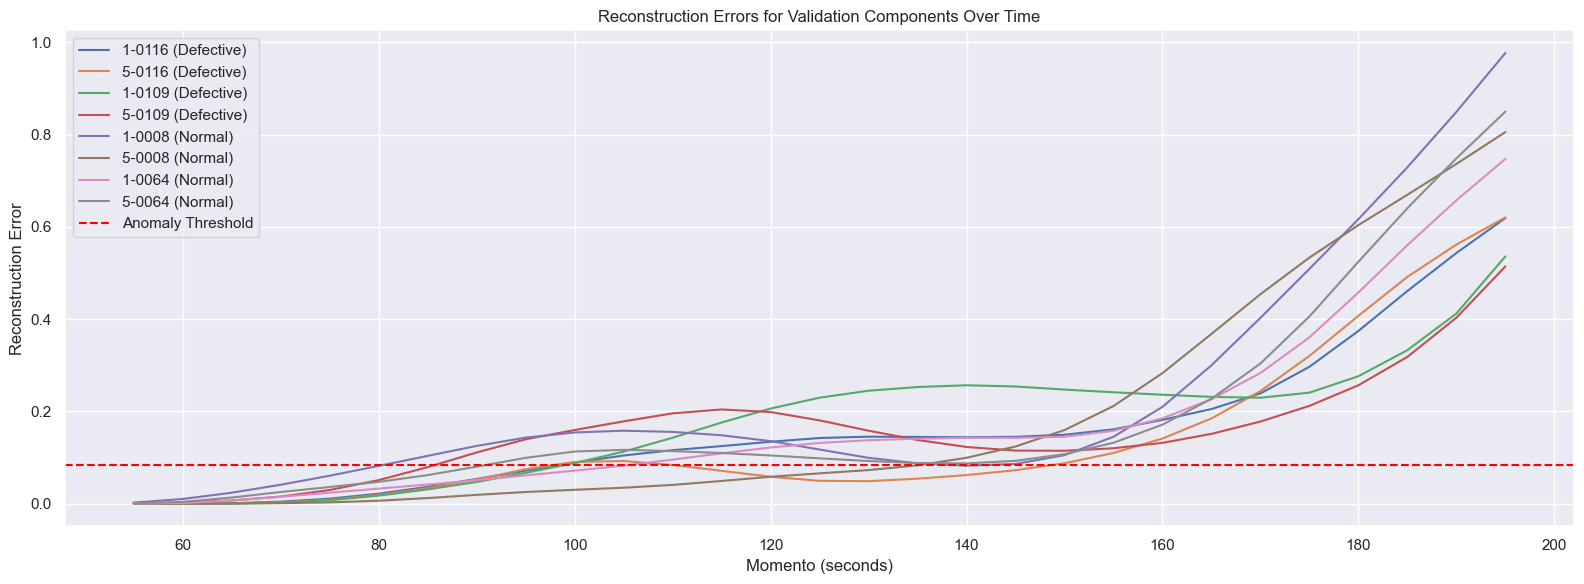

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# Label columns nicely
labels = [
    f"{col} (Defective)" if col in defective_columns else f"{col} (Normal)"
    for col in true_validation_columns
]

# Plot each validation column
for i in range(focused_errors.shape[1]):
    plt.plot(window_momentos, focused_errors[:, i], label=labels[i])

# Draw anomaly threshold line
plt.axhline(y=threshold, color='red', linestyle='--', label='Anomaly Threshold')

plt.title("Reconstruction Errors for Validation Components Over Time")
plt.xlabel("Momento (seconds)")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [85]:
# Boolean array: any of the 8 columns above threshold
anomalies = (focused_errors > threshold).any(axis=1)

# Get corresponding momentos
anomaly_times = np.array(window_momentos)[anomalies]

print("Anomaly detected at momento values:")
print(anomaly_times)


Anomaly detected at momento values:
[ 85  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170
 175 180 185 190 195]


In [86]:
print("focused_errors shape:", focused_errors.shape)
print("Number of window momentos:", len(window_momentos))


focused_errors shape: (29, 8)
Number of window momentos: 29


In [88]:
# Calculate per-feature reconstruction errors per window
per_feature_errors = np.square(X_val - X_val_pred)  # shape (windows, timesteps, features)

# Average over timesteps to get per-window, per-feature errors
avg_per_feature = np.mean(per_feature_errors, axis=1)  # shape (windows, features)

# Real validation columns are the first 8 features in X_val (indices 0 to 7)
col_indices = list(range(8))

focused_errors = avg_per_feature[:, col_indices]  # shape (windows, 8)


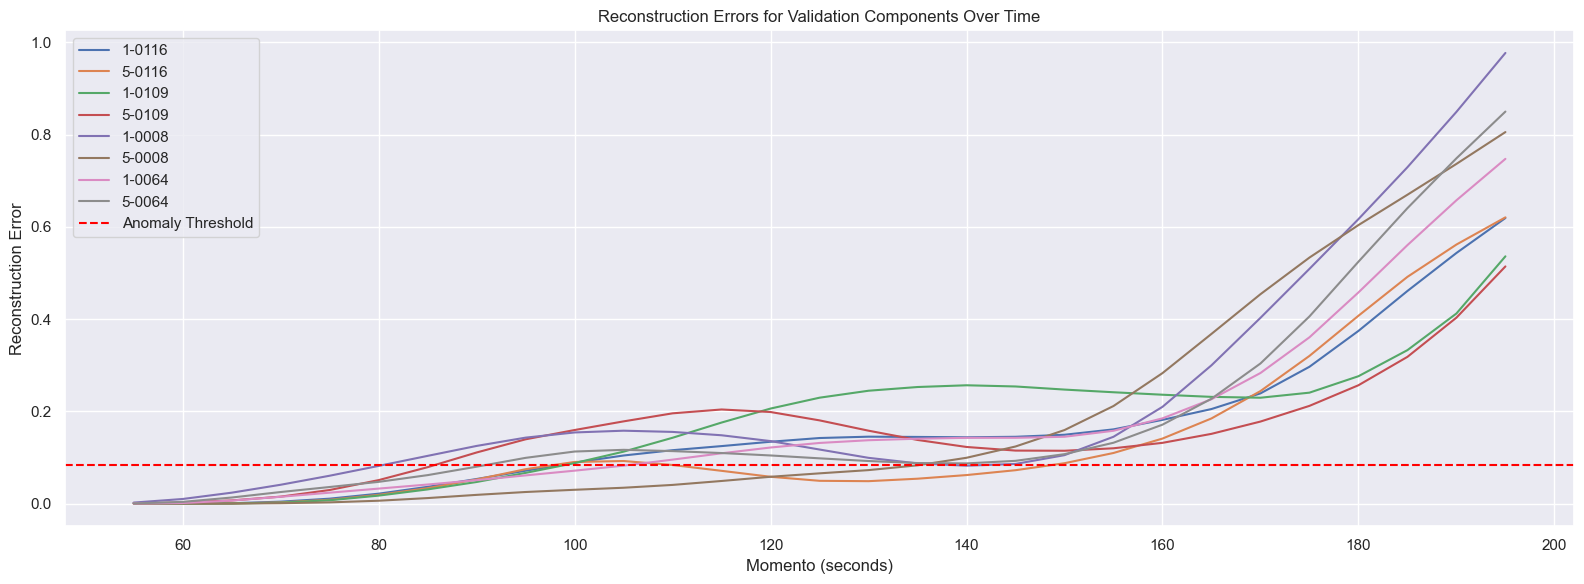

In [89]:
import matplotlib.pyplot as plt

labels = defective_columns + normal_control_columns  # your 8 real validation columns

plt.figure(figsize=(16, 6))
for i in range(focused_errors.shape[1]):
    plt.plot(window_momentos, focused_errors[:, i], label=labels[i])

plt.axhline(y=threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title("Reconstruction Errors for Validation Components Over Time")
plt.xlabel("Momento (seconds)")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
